In [ ]:
#bibliotecas que serão utilizadas durante os scripts

import os
import torch
import numpy as np
from PIL import Image
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader, Dataset
import easyocr
import matplotlib.pyplot as plt

In [ ]:
class YOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None): 
        #construtor da classe, inicia diretórios de imagens e rótulos, além de transformações
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms

        #lista apenas arquivos de imagens jpg e png
        self.img_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        #retorna o numero das imagens do dataset
        return len(self.img_files)

    def __getitem__(self, idx):
        #pega o numero da imagem e rótulo com base no índice
        img_name = self.img_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, os.path.splitext(img_name)[0] + '.txt')

        #pega a largura e altura da imagem 
        img = Image.open(img_path).convert("RGB")
        w, h = img.size


        boxes = []
        labels = []

        #processa cada linha para converter as anotações do formato YOLO
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    cls = int(parts[0]) + 1  # classes a partir de 1 (0 = background)
                    x_center, y_center, width, height = map(float, parts[1:])

                    #converte do formato YOLO para coordenadas absolutas
                    xmin = (x_center - width/2) * w
                    ymin = (y_center - height/2) * h
                    xmax = (x_center + width/2) * w
                    ymax = (y_center + height/2) * h
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(cls)

        #converte as listas e rótulos para tensortes Pytorch 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        #aplica as tranformações
        if self.transforms:
            img = self.transforms(img)

        return img, target #retorna as imagens e os rótulos

In [ ]:
#diretório onde estão os datasets
dataset_path = './data' 
images_train = os.path.join(dataset_path, 'images/train')
labels_train = os.path.join(dataset_path, 'labels/train')

#transformações aplicadas às imagens: converte imagens PIL para tensores PyTorch
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [ ]:
#cria uma instância do dataset personalizado, passando os diretórios de imagens e rótulos de treino,
# além das transformações definidas anteriormente
dataset_train = YOLODataset(images_train, labels_train, transforms=transforms)

#cria um dataloader para carregar os dados em mini-batches
train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
#define o dispositivo a ser usado GPU ou CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

#carrega o modelo
model = fasterrcnn_resnet50_fpn(pretrained=True)

#substitui o cabeçalho de classificação (box predictor) para ajustar ao número de classes do problema atual
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 53.6MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#seleciona apenas o parametros que serão atualizados
params = [p for p in model.parameters() if p.requires_grad]

#define o otimizador SGD
optimizer = torch.optim.SGD(params, lr=0.002, momentum=0.9, weight_decay=0.0005)

In [ ]:
num_epochs = 15 #numero de épocas para treinamento
losses_per_epoch = [] #lista para armazenar o loss médio de cada época

#loop de treinamento por época
for epoch in range(num_epochs):
    model.train() #coloca o modelo em modo de treinamento
    epoch_loss = 0.0

    #iteração pelos batches do dataloader
    for imgs, targets in train_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Calcula o dicionário de losses do modelo
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        #passos de otimização
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    #calcula a média do loss da época
    avg_loss = epoch_loss / len(train_loader)
    losses_per_epoch.append(avg_loss)  # armazenamento para o gráfico

    #printa o progresso do loss das épocas
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/15] - Loss: 0.2978
Epoch [2/15] - Loss: 0.1837
Epoch [3/15] - Loss: 0.1444
Epoch [4/15] - Loss: 0.1341
Epoch [5/15] - Loss: 0.1216
Epoch [6/15] - Loss: 0.0996
Epoch [7/15] - Loss: 0.0828
Epoch [8/15] - Loss: 0.0655
Epoch [9/15] - Loss: 0.0586
Epoch [10/15] - Loss: 0.0489
Epoch [11/15] - Loss: 0.0438
Epoch [12/15] - Loss: 0.0369
Epoch [13/15] - Loss: 0.0331
Epoch [14/15] - Loss: 0.0292
Epoch [15/15] - Loss: 0.0273


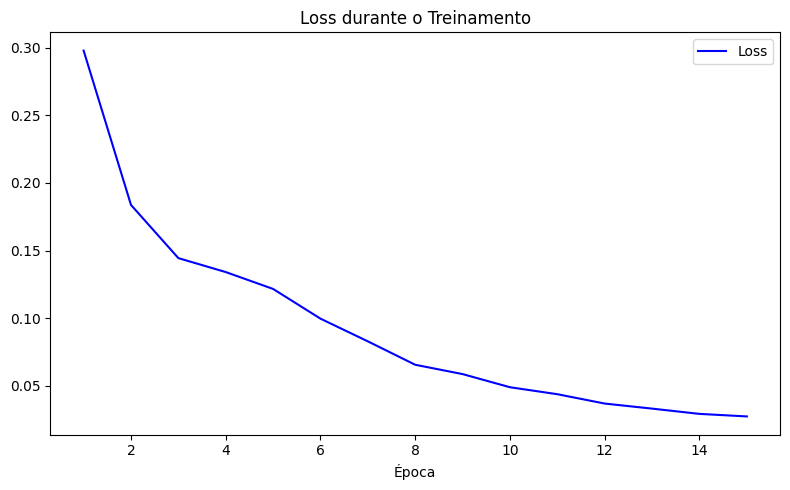

In [9]:
#gráfico da loss após o treinamento
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), losses_per_epoch, color='blue', label='Loss')
plt.xlabel('Época')
plt.title('Loss durante o Treinamento')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#inicializa o leitor OCR do EasyOCR com suporte para português
reader = easyocr.Reader(['pt'], gpu=torch.cuda.is_available())

#função que detecta as placas em uma imagem e aplica OCR nas regiões detectadas
def detect_and_ocr_on_image(image_path, model, reader, device):
    
    model.eval() #coloca o modelo em modo de avaliação

    #abre a imagem, converte para RGB e transforma em tensor
    img_pil = Image.open(image_path).convert("RGB")
    transform = torchvision.transforms.ToTensor()
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    #desativa o cálculo de gradientes
    with torch.no_grad():
        output = model(img_tensor)[0]

    #converte a imagem PIL para array NumPy
    img_np = np.array(img_pil)

    #extrai scores e bounding boxes do resultado da detecção
    scores = output['scores'].cpu().numpy()
    boxes = output['boxes'].cpu().numpy()
    
    #cria a figura para exibir a imagem e as anotações
    fig, ax = plt.subplots(1, figsize=(12,8))
    ax.imshow(img_np)

    #itera sobre cada caixa detectada
    for box, score in zip(boxes, scores):

        #converte as coordenadas da caixa para inteiros
        xmin, ymin, xmax, ymax = box.astype(int)
        pad = 5
        xmin = max(xmin - pad, 0)
        ymin = max(ymin - pad, 0)
        xmax = min(xmax + pad, img_np.shape[1])
        ymax = min(ymax + pad, img_np.shape[0])

        cropped = img_np[ymin:ymax, xmin:xmax]

        #OCR
        result = reader.readtext(cropped)
        print(f"Placa detectada (score {score:.2f}):", result)

        #desenhar box e texto
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        #escreve o texto detectado acima da caixa, se o OCR detectar algo
        for (bbox, text, conf) in result:
            ax.text(xmin, ymin - 10, f'{text} ({conf:.2f})',
                    color='yellow', fontsize=10, backgroundcolor='black')

    plt.axis('off')
    plt.show()

Placa detectada (score 1.00): [([[0, np.int32(12)], [np.int32(88), np.int32(12)], [np.int32(88), np.int32(36)], [0, np.int32(36)]], 'WI2', np.float64(0.15677573223593555))]
Placa detectada (score 0.84): [([[np.int32(12), np.int32(20)], [np.int32(62), np.int32(20)], [np.int32(62), np.int32(50)], [np.int32(12), np.int32(50)]], 'L@', np.float64(0.166036807568032)), ([[np.int32(70), np.int32(8)], [np.int32(134), np.int32(8)], [np.int32(134), np.int32(60)], [np.int32(70), np.int32(60)]], '50', np.float64(0.8514844992221609))]
Placa detectada (score 0.07): []


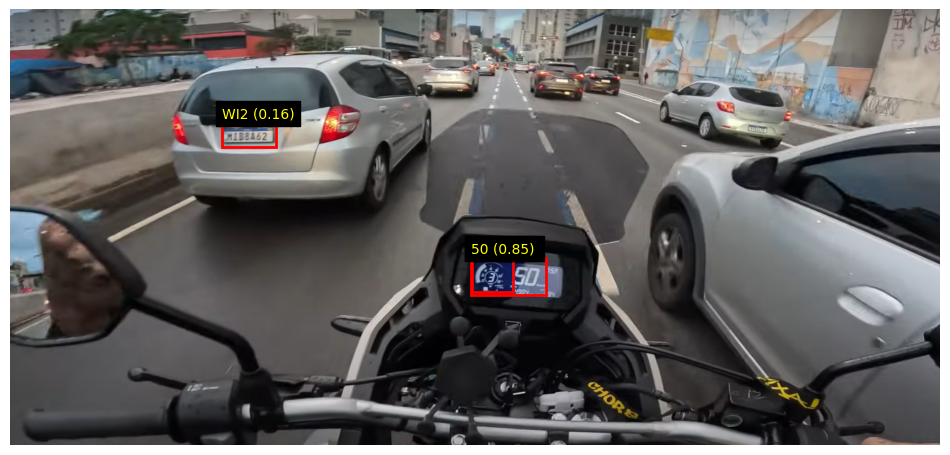

In [ ]:
detect_and_ocr_on_image('mercosul.png', model, reader, device) #aplicação da função de detecção


Placa detectada (score 1.00): [([[0, np.int32(17)], [np.int32(125), np.int32(17)], [np.int32(125), np.int32(43)], [0, np.int32(43)]], 'AYros49', np.float64(0.15139869574590842))]


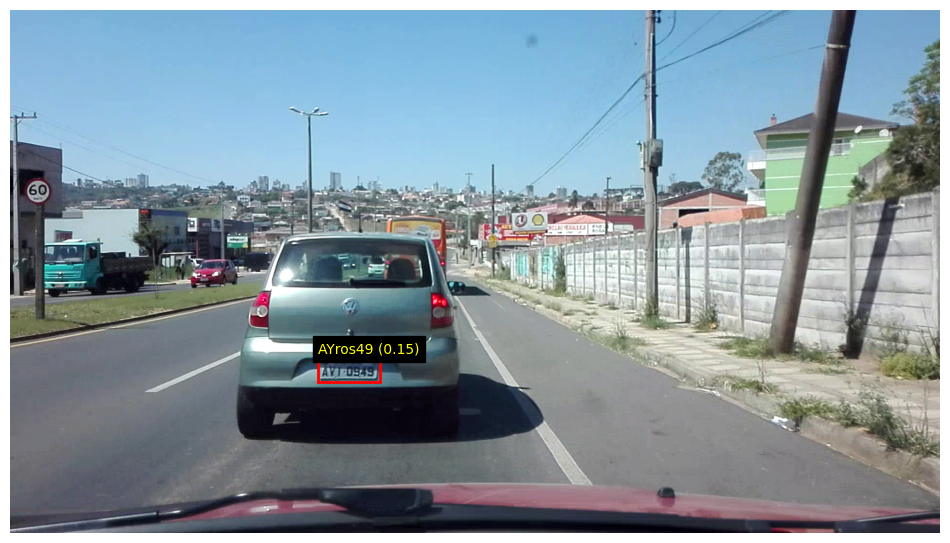

In [ ]:
detect_and_ocr_on_image('antiga1.png', model, reader, device) #aplicação da função de detecção

Placa detectada (score 0.96): [([[np.int32(11), np.int32(19)], [np.int32(77), np.int32(19)], [np.int32(77), np.int32(59)], [np.int32(11), np.int32(59)]], '633e', np.float64(0.3523227274417877))]
Placa detectada (score 0.13): []


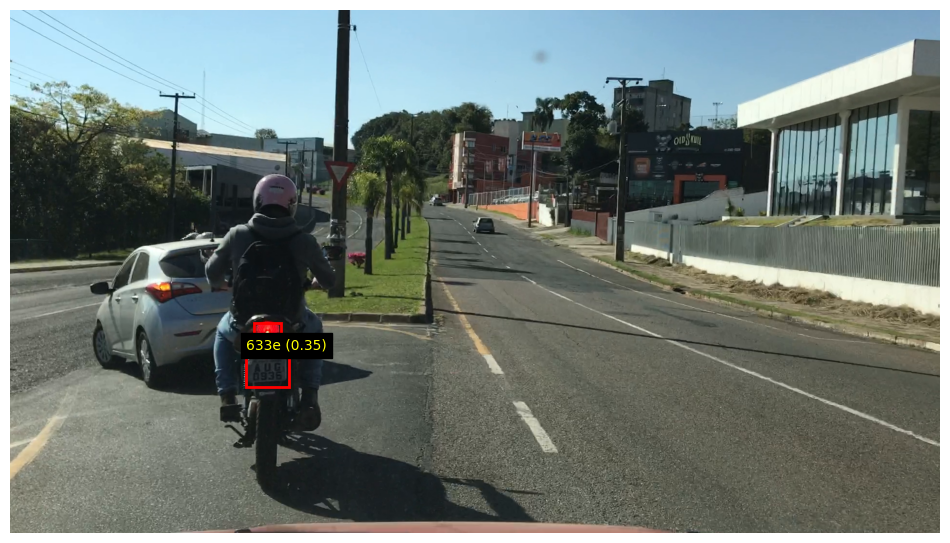

In [ ]:
detect_and_ocr_on_image('antiga.png', model, reader, device) #aplicação da função de detecção

Placa detectada (score 0.58): [([[np.float64(65.00636944292775), np.float64(20.414649718733827)], [np.float64(152.06495243046203), np.float64(7.088615151155576)], [np.float64(156.99363055707224), np.float64(52.58535028126617)], [np.float64(69.93504756953797), np.float64(65.91138484884442)]], "'7337", np.float64(0.8444553996626007)), ([[np.float64(-4.99363055707225), np.float64(37.41464971873383)], [np.float64(69.62499716797207), np.float64(21.556252690426533)], [np.float64(77.99363055707225), np.float64(69.58535028126617)], [np.float64(2.3750028320279313), np.float64(85.44374730957347)]], 'GDB;', np.float64(0.48443108797073364))]
Placa detectada (score 0.08): [([[np.float64(-0.9936305570722499), np.float64(19.414649718733827)], [np.float64(80.80829378812018), np.float64(3.760108269808201)], [np.float64(87.99363055707225), np.float64(51.58535028126617)], [np.float64(6.191706211879815), np.float64(67.2398917301918)]], 'Gdb;=', np.float64(0.14241473511445776))]


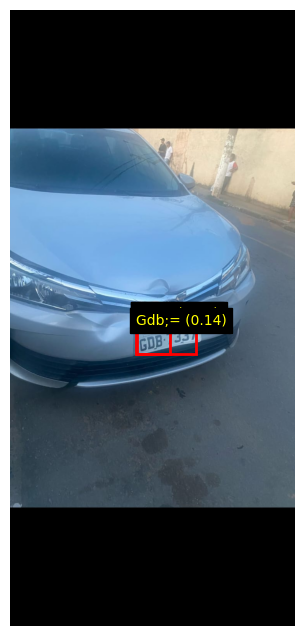

In [ ]:
detect_and_ocr_on_image('teste.jpg', model, reader, device) #aplicação da função de detecção
